In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")

In [2]:
aggregate=pd.read_csv('./aggregate.csv',engine='python')
aggregate.set_index('GEO_ID',inplace=True)
agg_train, agg_test = train_test_split(aggregate,test_size=0.2,shuffle=True,random_state=121) # Split dataset into 80%-20% training and testing, random_state=121 for consistency

#Construct extra features for use in the models
agg_train['unemp_bac']=agg_train['unemp_rate']*agg_train['bac_deg']
agg_train['log_pop']=np.log10(agg_train['total_pop'].apply(lambda x: max(x,0.1)))
agg_train['log_urban_pop']=np.log10((agg_train['urban']*agg_train['total_pop']).apply(lambda x: max(x,0.1)))
for x in agg_train.index:
    agg_train.loc[x,'winner'] = 'D' if agg_train.loc[x,'democrat'] > agg_train.loc[x,'republican'] else 'R' #For classifer problems: determine winner in each county

features=['white_pc','urban', 'unemp_bac', 'log_pop','log_urban_pop','pov_pc', 'unemp_rate', 'bac_deg', 'hs_deg', 'pop_18_30_pc', 'pop_60_up_pc'] #list of features we want to use
results=['democrat','republican']
target='democrat' #target variable, 'republican'=100-'democrat' approximately

In [3]:
#powerset function to construct powerset of a set excluding the empty subset
def powerset(l):
    pl=[[]]
    for x in l:
        pl=pl+[y+[x] for y in pl]
    return pl[1:]

In [4]:
n=5
kfold=KFold(n_splits=n,shuffle=True,random_state=121) #5-fold split, random_state=121 for consistency
allfeatures=powerset(features) 
mse=np.zeros(len(allfeatures)+1) #array to store average mse, the last entry used for baseline pred
r2=np.zeros(len(allfeatures)+1)
for train_i, test_i in kfold.split(agg_train):
    train_var = agg_train.iloc[train_i]
    test_var = agg_train.iloc[test_i]
    baseline=np.ones(len(test_var))*(train_var[target].values.mean()) #baseline prediction, arithmetic mean of the vote percentages
    mse[-1] += mean_squared_error(baseline, test_var[target])
    for i,featureset in enumerate(allfeatures):       
        lr=LinearRegression()
        if(len(featureset))==1: #Need to consider the case of one feature separately since we need to reshape the feature column
            lr.fit(train_var[featureset].values.reshape(-1,1),train_var[target])
            mse[i] += mean_squared_error(lr.predict(test_var[featureset].values.reshape(-1,1)),test_var[target])
            r2[i] += r2_score(lr.predict(test_var[featureset].values.reshape(-1,1)),test_var[target])
        else:
            lr.fit(train_var[featureset].values,train_var[target])
            mse[i] += mean_squared_error(lr.predict(test_var[featureset].values),test_var[target])
            r2[i] += r2_score(lr.predict(test_var[featureset].values),test_var[target])

mse = mse / n #average the mse over cross-validation loops


In [5]:
mse[-1] #baseline mse

254.95368251166732

In [6]:
mse.min(), mse.argmin(), r2.max(),r2.argmax() #minimum mse & maximum coefficient of determination and index of features

(84.61319073304699, 2030, 2.5135060131054243, 2030)

In [7]:
#optimal list of features
featureset=allfeatures[mse.argmin()]
print(featureset)

['white_pc', 'urban', 'unemp_bac', 'log_pop', 'pov_pc', 'unemp_rate', 'bac_deg', 'hs_deg', 'pop_18_30_pc', 'pop_60_up_pc']


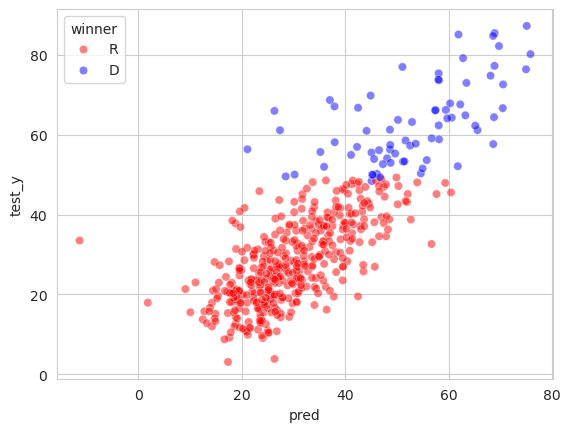

In [8]:
#Example chart for the test instance of the last iteration of cross-validation

lr=LinearRegression()
lr.fit(train_var[featureset].values,train_var['democrat'])
pred=pd.DataFrame({'pred':lr.predict(test_var[featureset].values),'test_y':test_var['democrat'].values,'winner':test_var['winner'].values})
sns.scatterplot(data=pred,x='pred',y='test_y',hue='winner',palette=['red','blue'], alpha=0.5)
plt.show()

<Axes: >

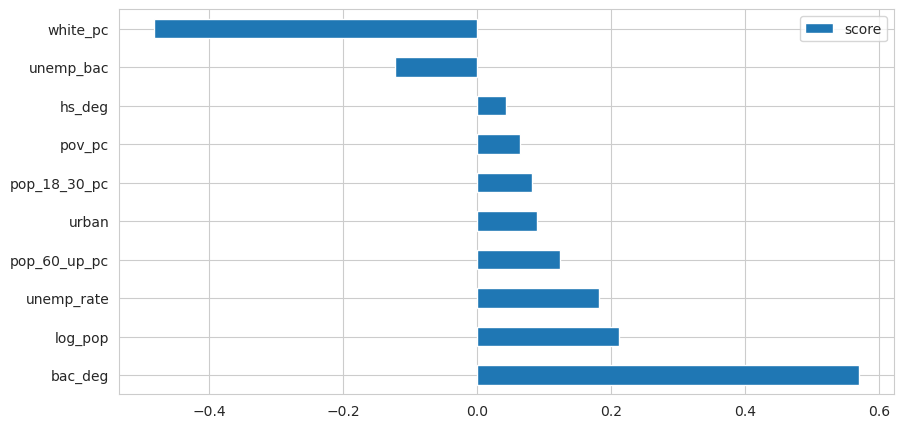

In [11]:
Features=['white_pc','urban', 'unemp_bac', 'log_pop','log_urban_pop','pov_pc', 'unemp_rate', 'bac_deg', 'hs_deg', 'pop_18_30_pc', 'pop_60_up_pc', 'democrat', 'republican'] #list of features we want to use
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_var[Features])
scaled_train_var = pd.DataFrame(scaled_data, columns=Features)
lr_scaled=LinearRegression()
lr_scaled.fit(scaled_train_var[featureset].values,scaled_train_var['democrat'])
importance = lr_scaled.coef_ 
importance, featureset

data = pd.DataFrame(data=importance, index=featureset, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (10,5))